In [18]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from Systems.DuffingSystem import *
from Systems.Generate_Data import *
from HamiltonianNeuralNetwork.pHNN import *
from NumericalIntegration.Numerical_Integration import *

torch.random.manual_seed(1)
np.random.seed(33)

plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 10
colors = sns.color_palette([(0.6,0.8,.8), (1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0,0.4,1), (0.6,0.5,.9), (0.5,0.3,.5)])

In [19]:
def initial_condition():
    def sampler():
        u0 =  np.random.rand(2) * 2 - 1
        radius = np.sqrt(np.random.uniform(0.5, 1.5))  
        u0 /= np.sqrt((u0 ** 2).sum()) * (radius)
        #u0 = np.random.rand(2)*0
        return u0.flatten()
    return sampler()

In [20]:

def generate_data(ntrajectories, t_sample,system,integrator, true_derivatives = False,H0=None,u0s=None,data_type = torch.float32):
    #Parameters
    nstates = system.nstates
    traj_length = t_sample.shape[0] 

    #Initializing 
    u = np.zeros((ntrajectories,traj_length,nstates))
    dudt = np.zeros_like(u)
    t = np.zeros((ntrajectories,traj_length))

    u0_ = np.zeros((ntrajectories,nstates))

    for i in tqdm(range(ntrajectories)):
        if u0s is not None:
            u0 = np.array(u0s[i])
            u[i], dudt[i], t[i],u0_[i] = system.sample_trajectory(t=t_sample,u0=u0,integrator=integrator)
        else:
            u[i], dudt[i], t[i],u0_[i] = system.sample_trajectory(t=t_sample,integrator=integrator)
    
    #Reshaping
    dt = torch.tensor([t[0, 1] - t[0, 0]], dtype=data_type)
    u_start = torch.tensor(u[:, :-1], dtype=data_type).reshape(-1, nstates)
    u_end = torch.tensor(u[:, 1:], dtype=data_type).reshape(-1, nstates)
    t_start = torch.tensor(t[:, :-1], dtype=data_type).reshape(-1, 1)
    dt = dt * torch.ones_like(t_start, dtype=data_type)

    if true_derivatives:
        dudt = torch.tensor(dudt[:, :-1], dtype=data_type).reshape(-1, 1, nstates)
    else:
        dudt = (u_end - u_start).clone().detach() / dt[0, 0]

    u_exact = u
    return (u_start, u_end,t_start, dt), dudt, u_exact, u0_

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import trange
import datetime


def Batch_Data(data,batch_size,shuffle):
    #Power of 2
    """
    data : tuple ((x_start, x_end, t_start, t_end, dt, u), dxdt)
    batch_size : int
    shuffle : bool
    """
    nsamples = data[1].shape[0]

    if shuffle:
        permutation = torch.randperm(nsamples)
    else:
        permutation = torch.arange(nsamples)

    nbatches = np.ceil(nsamples/batch_size).astype(int)
    batched = [(None,None)] *nbatches  #((x_start, x_end, t_start, t_end, dt, u), dxdt)

    for i in range(nbatches):
        indices = permutation[i * batch_size : (i + 1) * batch_size]
        input_tuple = [data[0][j][indices] for j in range(len(data[0]))]
        dudt = data[1][indices]
        batched[i] = (input_tuple, dudt)

    return batched


def penalty_loss(model,time, lam_F=1e-4,lam_N=1e-4):
    penalty = 0
    penalty += lam_F*torch.mean(torch.abs(model.External_Force(time.reshape(-1,1))))
    penalty += lam_N*torch.mean(torch.abs(model.Get_N()))
    return penalty

def train_one_epoch(model,batched_train_data,loss_func,optimizer,integrator):
    computed_loss = 0.0
    optimizer.zero_grad()
    for input_tuple, dudt in batched_train_data:
      
        (u_start, u_end, t_start, dt) = input_tuple
        n,m = u_start.shape
        #Reshaping
        if n ==1:
            u_start = u_start.view(-1)

        dudt = dudt.view(n,m)
        #Estimating dudt
        dudt_est = model.time_derivative_step(integrator = integrator, u_start = u_start,u_end = u_end,dt = dt)
        loss = loss_func(dudt_est,dudt)
        loss += penalty_loss(model,t_start)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        computed_loss += loss.item()

    return computed_loss / len(batched_train_data)

def compute_validation_loss(model, integrator, val_data, valdata_batched, loss_func):
    val_loss = 0
    if valdata_batched is not None:
        for input_tuple, dudt in valdata_batched:
            (u_start, u_end, t_start, dt) = input_tuple
            n,m = u_start.shape
            #Reshaping
            if n ==1:
                u_start = u_start.view(-1)
            #u_start = u_start.requires_grad_()
            dudt = dudt.view(n,m)
        
            dudt_est = model.time_derivative_step(integrator = integrator, u_start = u_start,u_end = u_end,dt = dt)

            val_loss += loss_func(dudt_est, dudt).item()
            val_loss += penalty_loss(model,t_start)
    else:
        (u_start, u_end, t_start, dt), dudt = val_data
        n,m = u_start.shape
        #Reshaping
        if n ==1:
            u_start = u_start.view(-1)
        #u_start = u_start.requires_grad_()
        dudt = dudt.view(n,m)
        dudt_est = model.time_derivative(integrator, u_start,u_end,dt)
        val_loss = loss_func(dudt_est, dudt).item()
        val_loss += penalty_loss(model,t_start).item()
    val_loss = val_loss / len(valdata_batched)
    return val_loss#.item() #float(val_loss.detach().numpy())
    

def train(model,integrator, train_data,val_data, optimizer,shuffle,loss_func=torch.nn.MSELoss(),batch_size=1024,epochs = 20, verbose =True):
    """
    traindata : tuple((x_start, x_end, t_start, t_end, dt, u), dxdt)
    optimizer : torch optimizer"""
   
    trainingdetails={}
    train_batch = Batch_Data(train_data, batch_size, shuffle)
    valdata_batched = Batch_Data(val_data, batch_size, False)

    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    loss_list = []
    val_loss_list =  []

    print("Batch data epoch len: ", len(train_batch))
    print("Batch data shape: ", train_batch[0][0][0].shape)

    with trange(epochs) as steps:
        for epoch in steps:
            if shuffle:
                train_batch = Batch_Data(train_data,batch_size,shuffle)
            model.train(True) 
            start = datetime.datetime.now() 
            avg_loss = train_one_epoch(model,train_batch,loss_func,optimizer,integrator)
            end = datetime.datetime.now() 
            print("Training loss: ",avg_loss)
            loss_list.append(avg_loss)
            model.train(False) 
            if verbose: #Print
                steps.set_postfix(epoch=epoch, loss=avg_loss)

            if val_data is not None:
                start = datetime.datetime.now()
                vloss = compute_validation_loss(model, integrator, val_data, valdata_batched, loss_func)
                end = datetime.datetime.now()
                print("Validation loss: ",vloss)
                val_loss_list.append(vloss)

            trainingdetails["epochs"] = epoch + 1
            trainingdetails["val_loss"] = vloss
            trainingdetails["train_loss"] = avg_loss




     # Plot the loss curve
    plt.figure(figsize=(7, 4))
    plt.plot(loss_list, label = "Training Loss")
    plt.plot(val_loss_list,label = "Validation Loss")
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    shape_data = (len(train_batch),train_batch[0][0][0].shape)

    return model,trainingdetails

In [26]:
T_max_train = 18000# 2*np.pi
alpha, beta, omega, gamma, delta = -1, 1, 1.4, 0.39, 0.1
nsamples_train = T_max_train/0.1#100*T_max_train/2
ntraj_train = 7
T_max_val = T_max_train
nsamples_val = nsamples_train
ntraj_val = 3
epochs = 50

batch_size = 64
lr = 1e-3

act_1 = PAU()
act_2 = PAU()
act_3 = nn.Softplus()



sys = DuffingSystem(alpha = alpha, beta = beta, omega = omega, delta = delta, gamma=gamma)

dt_train = T_max_train/nsamples_train
nt_train = round(T_max_train / dt_train)
t_train = np.linspace(0, T_max_train, nt_train + 1)

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

In [27]:
integrator = "midpoint"

(u_start, u_end, t_start, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator)
train_data = (u_start, u_end,t_start, dt), dudt

(u_start, u_end,t_start, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator)
val_data = (u_start, u_end, t_start, dt), dudt


100%|██████████| 3/3 [00:09<00:00,  3.29s/it]


In [30]:
u_train[0]

array([[ 0.50464316,  0.7838938 ],
       [ 0.58452124,  0.81693302],
       [ 0.66800223,  0.85479445],
       ...,
       [ 1.10153028, -0.88586326],
       [ 1.01056526, -0.92352581],
       [ 0.91679096, -0.94396393]], shape=(180001, 2))

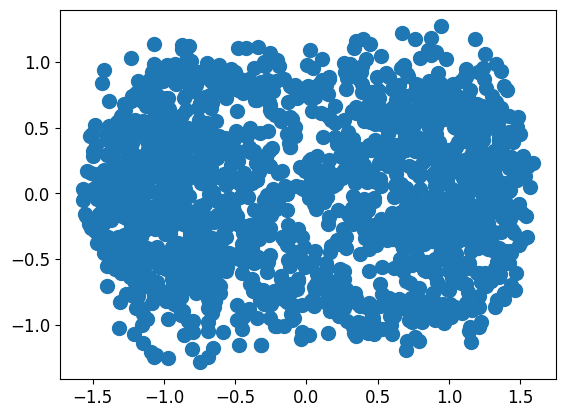

In [28]:
pstep = 100
plt.scatter(u_train[0][::pstep,0],u_train[0][::pstep,1])

In [ ]:
Hamiltonian_est = BaseHamiltonianNeuralNetwork(nstates = 2, act_1 = act_1, act_2 = act_2, act_3 = act_3)
External_Forces_est = ExternalForceNeuralNetwork(nstates = 2, act_1 = act_1, act_2 = act_2, act_3 = act_3)


model_exp = PortHamiltonianNeuralNetwork(nstates = 2, S = sys.S, Hamiltonian_est = Hamiltonian_est, External_Forces_est = External_Forces_est)

optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=lr)

model_exp, trainingdetails_explicit = train(model=model_exp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_exp,loss_func=torch.nn.MSELoss(),batch_size=batch_size,epochs = epochs, shuffle = True, verbose =True)



TypeError: train() missing 1 required positional argument: 'shuffle'